# 模型介绍

前面几个模型都是10+层的小打小闹，这个网络一下就到了150+，最深还可以达到1000多。

其他一些理解：https://www.zhihu.com/question/64494691

目标问题：

    1、对VGG19，通过添加由conv3*3实现的identity mapping层来加深模型。
    2、理论上，更深的模型表现能力应该更好。
    3、但是，实验结果是，更深的模型表现能力更差了。————退化问题
    4、因此提出了新的解决方案。
 
退化问题：

    1、这里关于退化问题多说两句。
    2、发现退化问题：在plain network上加了identity mapping层后，发现更深的网络效果不好。
    3、然后觉得gradient vanish问题已经被batchnormalization解决了。
    4、觉得plain network难以学习到identity mapping，所以效果才这么差= -。
    5、额，所以从这个角度看，退化问题并不是一个推导出来的问题，而是一个由实验得出来的问题。
    6、而，gradient vanish，是从数学上证明了，会有这个问题= - 。

ResNet误差传递：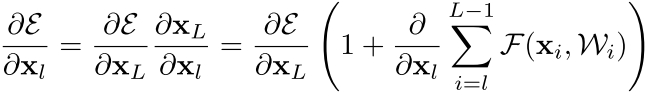

    1、这个传递保证了$∂E/∂xl$ 这一项不会衰减，而后面的又是累加，
    2、这两项都保证了误差在向后传播是，不会衰减。

ResNet解决结构：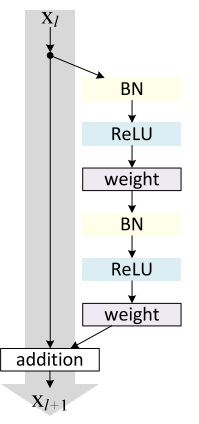


输入输出维度变化怎么办：

    1、首先明确一点，有conv，BN，ReLU的叫residual unit；另外一边叫shortcut。
    2、维度变化是指，网络生成过程中，我们会增加feature的数量，于此同时，feature map的size会减半。
    3、那么这个时候 residual unit的输入输出的size就不一致了，这个时候有这么3种方案：
        对shortcut处理：
            1、shortcut全部都用线性变换 Wl×Xl，来处理维度不一致。
            2、在residual unit输入输出维度一致的地方，直接用identity map；尺寸有变的地方，用线性变换。
        对residual unit处理：
            1、对featurea map利用zero padding来填充，shortcut直接就是identity map

    4、我们这个模型里面，采用的是residual unit一致的地方采用identity map；尺寸有变的地方采用线性变换


# 搭建模型

In [17]:
from keras.models import Model  
from keras.layers import Input,Dense,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,concatenate,Activation,ZeroPadding2D  
from keras.layers import add,Flatten
from keras.layers.core import Activation
import numpy as np 

In [18]:
# 基本的卷积+batchnormalization
# 试一下最优结构
def Conv2d_BN(x, nb_filter,kernel_size, strides=(1,1), padding='same',name=None):  
    if name is not None:  
        bn_name = name + '_bn'  
        conv_name = name + '_conv'  
    else:  
        bn_name = None  
        conv_name = None  
  
    x = BatchNormalization(axis=3,name=bn_name)(x)
    x = Activation('relu')(x)
    x = Conv2D(nb_filter,kernel_size,padding=padding,strides=strides,name=conv_name)(x)  
      
    return x  

In [19]:
'''
    残差单元：
        这里没有按照论文里的最优格式来（就是BN，在Relu，然后在Conv）
'''
def Conv_Block(inpt,nb_filter,kernel_size,strides=(1,1), with_conv_shortcut=False):  
    x = Conv2d_BN(inpt,nb_filter=nb_filter,kernel_size=kernel_size,strides=strides,padding='same')  
    x = Conv2d_BN(x, nb_filter=nb_filter, kernel_size=kernel_size,padding='same')
    
    if with_conv_shortcut:  
        shortcut = Conv2d_BN(inpt,nb_filter=nb_filter,strides=strides,kernel_size=(1,1))  
        x = add([x,shortcut])  
        return x  
    else:  
        x = add([x,inpt])  
        return x  

In [20]:
inpt = Input(shape=(224,224,3))  
x = ZeroPadding2D((3,3))(inpt) 

x = Conv2d_BN(x,nb_filter=64,kernel_size=(7,7),strides=(2,2),padding='valid')  
x = MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='same')(x)  

#(56,56,64)  
x = Conv_Block(x,nb_filter=64,kernel_size=(3,3))  
x = Conv_Block(x,nb_filter=64,kernel_size=(3,3))  
x = Conv_Block(x,nb_filter=64,kernel_size=(3,3))  

# (28,28,128)
# 处于filter交替位置的时候，所有的conv要以strides=2进行
x = Conv_Block(x,nb_filter=128,kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)  
x = Conv_Block(x,nb_filter=128,kernel_size=(3,3))  
x = Conv_Block(x,nb_filter=128,kernel_size=(3,3))  
x = Conv_Block(x,nb_filter=128,kernel_size=(3,3))  

#(14,14,256)  
x = Conv_Block(x,nb_filter=256,kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)  
x = Conv_Block(x,nb_filter=256,kernel_size=(3,3))  
x = Conv_Block(x,nb_filter=256,kernel_size=(3,3))  
x = Conv_Block(x,nb_filter=256,kernel_size=(3,3))  
x = Conv_Block(x,nb_filter=256,kernel_size=(3,3))  
x = Conv_Block(x,nb_filter=256,kernel_size=(3,3))  

#(7,7,512)  
x = Conv_Block(x,nb_filter=512,kernel_size=(3,3),strides=(2,2),with_conv_shortcut=True)  
x = Conv_Block(x,nb_filter=512,kernel_size=(3,3))  
x = Conv_Block(x,nb_filter=512,kernel_size=(3,3))

x = AveragePooling2D(pool_size=(7,7))(x)  
x = Flatten()(x)  
x = Dense(1000,activation='softmax')(x)  

batch_input_shape: (None, 224, 224, 3)


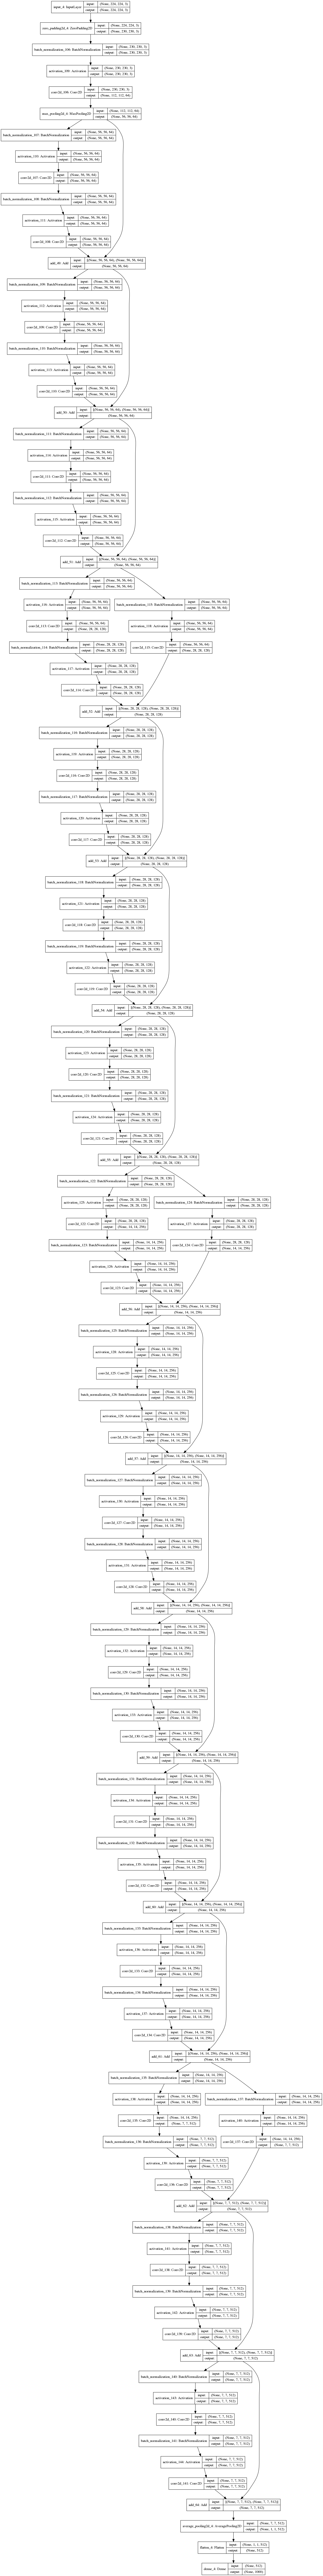

In [21]:
model=Model(inputs=inpt,outputs=x)

from keras.utils.vis_utils import plot_model

from IPython.display import Image



plot_model(model, to_file="model.png", show_shapes=True)

Image('model.png')